In [54]:
import pathlib
import re
import json
import pandas as pd
from collections import defaultdict
from tqdm import tqdm

# == Base ==
DATA_DIR = pathlib.Path("/data") / "radiology_datas"

# == Dataset ==
ADNI1 = DATA_DIR / "ADNI1"
ADNI2 = DATA_DIR / "JHU-radiology" / "20170509"
ADNI2_2 = DATA_DIR / "JHU-radiology" / "MNI_skull_stripped" / "output"
PPMI = DATA_DIR / "JHU-radiology" / "PPMI"
FourRTNI = DATA_DIR / "JHU-radiology" / "4RTNI"

BLACKLIST_DIR = DATA_DIR / "util" / "lists"

DATA_CSV = {
    "ADNI": DATA_DIR / "JHU-radiology" / "ADNIMERGE.csv",
    "PPMI": DATA_DIR / "JHU-radiology" / "PPMI.csv",
    "4RTNI": FourRTNI / "csv" / "4RTNI_DATA.csv",
}

DATA_DIRS_DICT = {
    "ADNI1": ADNI1,
    "ADNI2": ADNI2,
    "ADNI2-2": ADNI2_2,
    "PPMI": PPMI,
    "4RTNI": FourRTNI / "SkullStripped",
}

PTID = {"ADNI": "PTID", "PPMI": "Subject", "4RTNI": "SUBID"}
PTCLASS = {"ADNI": "DX_bl", "PPMI": "Group", "4RTNI": "DX"}


In [2]:
def get_uid(path):
    """
    pathを受け取ってuidを返すだけ
    Args
    ----------
    path : pathlib
        pklファイルへのパス
    Return
    ----------
    uid : int
        uid
    """
    uid = path.name
    for key, value in DATA_DIRS_DICT.items():
        if str(value) in str(path):

            if key == "ADNI2":
                uid = path.name.split("_")[-2]
                uid = int(uid[1:])

            elif key == "ADNI2-2":
                uid = path.name.split("_")[-4]
                uid = int(uid[1:])

            elif key == "PPMI":
                uid = path.name.split("_")[-4]
                uid = int(uid)

            elif key == "4RTNI":
                uid = path.name.split("_")[-4]
                uid = int(uid)

            return uid


def get_blacklist(dir):
    """
    brain/util/listsの中にいるblacklistたちをuidのリストで返す
    Args
    ----------
    Return
    ----------
    uid : list of int
        uids
    """
    key = "**/uids.txt"
    excluded_uid_paths = dir.glob(key)
    excluded_uids = []
    for path in excluded_uid_paths:
        with open(path, "r") as rf:
            [excluded_uids.append(int(uid.rstrip("\n"))) for uid in rf]
    return excluded_uids

black_list = get_blacklist(BLACKLIST_DIR)


In [36]:
contents = []
ptid_list = set([])

for csv_label, csv in DATA_CSV.items():

  df = pd.read_csv(csv)
  if csv_label == "4RTNI":
    df["DX"] = df["DX"].map(
        {"CBS": "CBD", "PSP": "PSP", "Oth": "Oth"}, na_action=None)

  for data in tqdm(df.to_dict(orient="records")):
    ptclass = data[PTCLASS[csv_label]]
    ptid = str(data[PTID[csv_label]])
    
    if ptid in ptid_list:
      continue
    else: 
      ptid_list.add(ptid)

    for label, dir in DATA_DIRS_DICT.items():
      try:
        path = pathlib.Path(dir / ptclass / ptid)
      except TypeError:
        path = pathlib.Path(dir / "Nan" / ptid)
        print(label, dir, ptclass, ptid, flush=True)

      files = [p for p in path.glob('**/*')
               if re.search('/*\.(pkl|npy)', str(p))]
      # files = list(path.glob("*.[p,n][k,p][l,y]"))
      if len(files) != 0:
        dataset = label
        break
    # if len(files) == 0:
      # print(f"該当ファイルなし, {label=}, {ptclass=}, {ptid=}")

    add_list = defaultdict(lambda :defaultdict(list))
    for f in files:
      f_temp = str(f).split("/")[-1]

      uid = get_uid(f)
      if f_temp.startswith("fullsize"):
        add_list[ptid][uid].append(("full", str(f)))
      if f_temp.startswith("half"):
        add_list[ptid][uid].append(("half", str(f)))

    for ptid, add_uid in add_list.items():
      images = []
      for uid, ls in add_uid.items():
        if uid not in black_list:
          blacklisted = False
        else:
          blacklisted = True
        
        for l in ls:
          if l[0] == "full":
            full = l[1]
          elif l[0] == "half":
            half = l[1]

        images.append(
          {
            "uid": uid,
            "blacklisted": blacklisted,
            "fullsize_img_path": full,
            "halfsize_img_path": half
          }
        )

      content = {
          "id": ptid,
          "class": ptclass,
          "images": images,
          "dataset": dataset
      }
      contents.append(content)

with open('./all_subject.json', 'w') as f:
  json.dump(contents, f, ensure_ascii=False, indent=2)

print(len(contents))


  0%|          | 0/124 [00:00<?, ?it/s]

ADNI1 /data/radiology_datas/ADNI1 nan 4_S_5010
ADNI2 /data/radiology_datas/JHU-radiology/20170509 nan 4_S_5010
ADNI2-2 /data/radiology_datas/JHU-radiology/MNI_skull_stripped/output nan 4_S_5010
PPMI /data/radiology_datas/JHU-radiology/PPMI nan 4_S_5010
4RTNI /data/radiology_datas/JHU-radiology/4RTNI/SkullStripped nan 4_S_5010


100%|██████████| 124/124 [00:00<00:00, 1129.22it/s]

1404


In [38]:
from load_images import load_images
images = load_images(datasets={"ADNI2"}, #, "ADNI2-2", "PPMI"},
                     classes={"CN", "AD"}, size="half", unique=False, blacklist=True, dryrun=False)
print(len(images))
images[0]

100%|██████████| 242/242 [00:00<00:00, 244.91it/s]

242


{'uid': 297310,
 'blacklisted': False,
 'fullsize_img_path': '/data/radiology_datas/JHU-radiology/20170509/AD/037_S_4001/fullsize_brain_flipRL_ADNI_037_S_4001_MR_MT1__GradWarp__N3m_Br_20120412210525847_S100198_I297310_MNI.pkl',
 'halfsize_img_path': '/data/radiology_datas/JHU-radiology/20170509/AD/037_S_4001/half_brain_flipRL_ADNI_037_S_4001_MR_MT1__GradWarp__N3m_Br_20120412210525847_S100198_I297310_MNI.pkl',
 'subject_id': '037_S_4001',
 'class': 'AD',
 'dataset': 'ADNI2',
 'voxel': array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],


In [19]:
import numpy as np
import matplotlib.pyplot as plt

def show_slice(gazo):

    def _voxel2slice(voxel: np.array, aspect: str, slice_idx: int) -> np.array:
        if aspect == 'sagittal':
            slice_img = np.flip(voxel.transpose((0, 2, 1))[slice_idx], 0)
        elif aspect == 'coronal':
            slice_img = np.flip(voxel.transpose((1, 2, 0))[slice_idx], 0)
        elif aspect == 'transverse':
            slice_img = np.flip(voxel.transpose((2, 1, 0))[slice_idx], 0)
        return slice_img

    fig = plt.figure(figsize=(9,3))
    trans = fig.add_subplot(1, 3, 1)
    trans.set_title("transverse", fontsize=12)
    trans.imshow(_voxel2slice(gazo, 'transverse', 50), cmap='gray')
    coronal = fig.add_subplot(1, 3, 2)
    coronal.set_title("coronal", fontsize=12)
    coronal.imshow(_voxel2slice(gazo, 'coronal', 50), cmap='gray')
    sagittal = fig.add_subplot(1, 3, 3)
    sagittal.set_title("sagittal", fontsize=12)
    sagittal.imshow(_voxel2slice(gazo, 'sagittal', 50), cmap='gray')

    plt.show()

In [20]:
start = 0
num = 10

/data/radiology_datas/JHU-radiology/20170509/AD/037_S_4001/half_brain_flipRL_ADNI_037_S_4001_MR_MT1__GradWarp__N3m_Br_20120412210525847_S100198_I297310_MNI.pkl


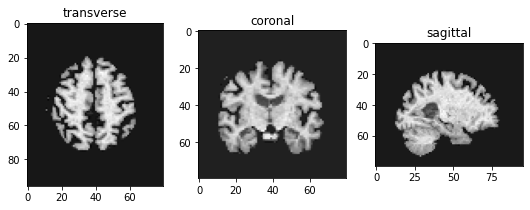

/data/radiology_datas/JHU-radiology/20170509/AD/037_S_4001/half_brain_flipRL_ADNI_037_S_4001_MR_MT1__GradWarp__N3m_Br_20120412210525847_S100198_I297310_MNI.pkl


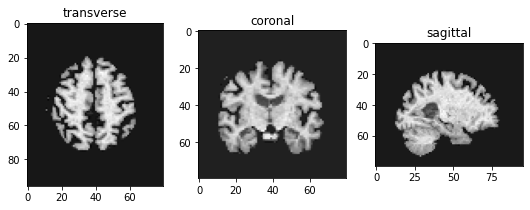

/data/radiology_datas/JHU-radiology/20170509/AD/037_S_4001/half_brain_flipRL_ADNI_037_S_4001_MR_MT1__GradWarp__N3m_Br_20120412210525847_S100198_I297310_MNI.pkl


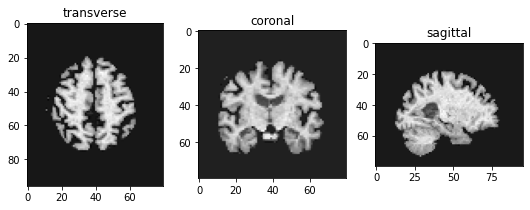

/data/radiology_datas/JHU-radiology/20170509/CN/116_S_4010/half_brain_flipRL_ADNI_116_S_4010_MR_MT1__GradWarp__N3m_Br_20110421132824150_S102845_I228507_MNI.pkl


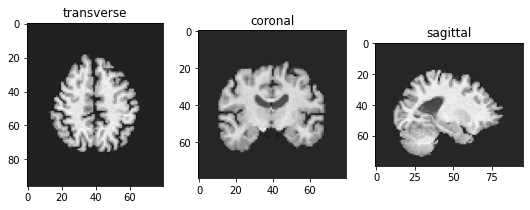

/data/radiology_datas/JHU-radiology/20170509/CN/041_S_4014/half_brain_flipRL_ADNI_041_S_4014_MR_MT1__GradWarp__N3m_Br_20110427155103716_S104714_I229335_MNI.pkl


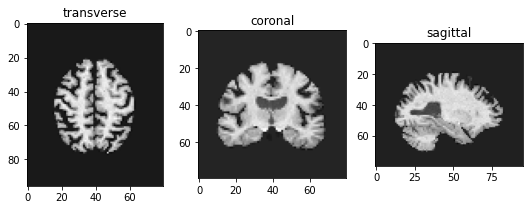

/data/radiology_datas/JHU-radiology/20170509/CN/041_S_4014/half_brain_flipRL_ADNI_041_S_4014_MR_MT1__GradWarp__N3m_Br_20110427155103716_S104714_I229335_MNI.pkl


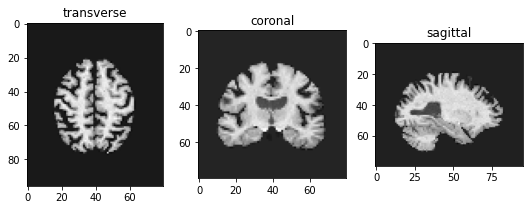

/data/radiology_datas/JHU-radiology/20170509/CN/023_S_4020/half_brain_flipRL_ADNI_023_S_4020_MR_MT1__GradWarp__N3m_Br_20110505163410626_S107436_I233460_MNI.pkl


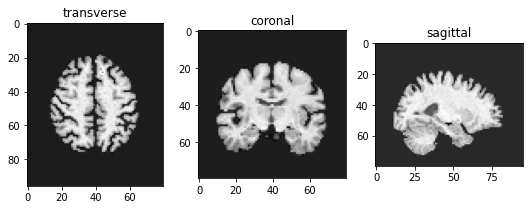

/data/radiology_datas/JHU-radiology/20170509/CN/023_S_4020/half_brain_flipRL_ADNI_023_S_4020_MR_MT1__GradWarp__N3m_Br_20110505163410626_S107436_I233460_MNI.pkl


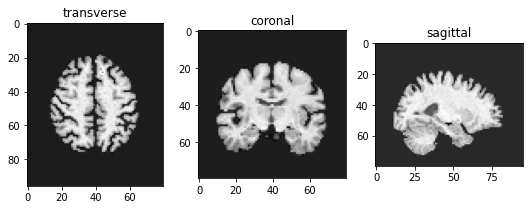

/data/radiology_datas/JHU-radiology/20170509/CN/031_S_4021/half_brain_flipRL_ADNI_031_S_4021_MR_MT1__N3m_Br_20110504105111444_S105268_I232862_MNI.pkl


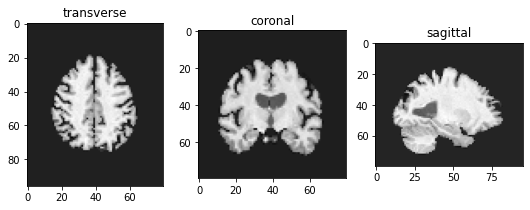

/data/radiology_datas/JHU-radiology/20170509/CN/031_S_4021/half_brain_flipRL_ADNI_031_S_4021_MR_MT1__N3m_Br_20110504105111444_S105268_I232862_MNI.pkl


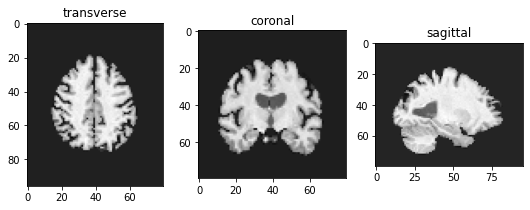

In [21]:
for image in images[start:start+num]:
  print(image['halfsize_img_path'], flush=True)
  show_slice(image['voxel'])

In [6]:
json_open = open("./all_subjects.json", "r")
json_load = json.load(json_open)
print(len(json_load))
class_set = set([j['class'] for j in json_load])
print(class_set)
json_load[0]

2218
{'AD', 'PD', 'PSP', 'control_subject', 'early_hd', 'SWEDD', 'premanifest_gene_carrier', 'EMCI', 'MCI', 'SMC', 'Oth', 'CBD', 'Prodromal', 'LMCI', 'CN', 'Control'}


{'id': '002_S_4473',
 'class': 'EMCI',
 'images': [{'uid': 'I285129',
   'blacklisted': False,
   'fullsize_img_path': '/data/radiology_datas/JHU-radiology/20170509/EMCI/002_S_4473/fullsize_brain_flipRL_ADNI_002_S_4473_MR_MT1__N3m_Br_20120216103716360_S140453_I285129_MNI.pkl',
   'halfsize_img_path': '/data/radiology_datas/JHU-radiology/20170509/EMCI/002_S_4473/half_brain_flipRL_ADNI_002_S_4473_MR_MT1__N3m_Br_20120216103716360_S140453_I285129_MNI.pkl'}],
 'dataset': 'ADNI2'}

In [39]:
json_open = open("./all_subject.json", "r")
json_load = json.load(json_open)
print(len(json_load))
class_set = set([j['class'] for j in json_load])
print(class_set)
json_load[0]

1404
{'AD', 'PD', 'PSP', 'SWEDD', 'EMCI', 'Oth', 'SMC', 'CBD', 'Prodromal', 'LMCI', 'CN', 'Control'}


{'id': '011_S_0002',
 'class': 'CN',
 'images': [{'uid': 35475,
   'blacklisted': False,
   'fullsize_img_path': '/data/radiology_datas/JHU-radiology/MNI_skull_stripped/output/CN/011_S_0002/fullsize011_S_0002_2005-08-26_S9107_I35475_flipped_MNI_SS.pkl',
   'halfsize_img_path': '/data/radiology_datas/JHU-radiology/MNI_skull_stripped/output/CN/011_S_0002/half_011_S_0002_2005-08-26_S9107_I35475_flipped_MNI_SS.pkl'}],
 'dataset': 'ADNI2-2'}

In [53]:
df1 = pd.read_csv(DATA_CSV['ADNI'])
print(set(df1.DX_bl))

df2 = pd.read_csv(DATA_CSV['PPMI'])
print(set(df2.Group))

df3 = pd.read_csv(DATA_CSV['4RTNI'])
print(set(df3.DX))


{'AD', 'EMCI', 'SMC', 'LMCI', 'CN'}
{'PD', 'SWEDD', 'Prodromal', 'Control'}
{'PSP', nan, 'Oth', 'CBS'}
